In [2]:
!pip install docplex
!pip install cplex


In [3]:
pip install networkx pandas matplotlib numpy docplex cplex openpyxl


Note: you may need to restart the kernel to use updated packages.


In [4]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as rnd
import math as mt
import docplex.mp
from docplex.mp.model import Model
from cplex.callbacks import LazyConstraintCallback, UserCutCallback
from docplex.mp.callbacks.cb_mixin import ConstraintCallbackMixin

In [ ]:
veh_speed = 35
P = 0.02           # percent of mean distance for interval of distance

In [6]:
depot_coor = pd.read_excel(r"C:\Users\lanan\Downloads\Tối ưu hóa trong quản lí định lượng\Final exam\Dataset .xlsx", sheet_name="Depot Details")
customer_det = pd.read_excel(r"C:\Users\lanan\Downloads\Tối ưu hóa trong quản lí định lượng\Final exam\Dataset .xlsx", sheet_name="Customer Details")
depot_coor_copy = depot_coor.drop("Depot", axis=1)
customer_det_copy = customer_det.drop("Customer", axis=1)
depot_coor.index = list(depot_coor["Depot"])
customer_det.index = list(customer_det["Customer"])

In [7]:
all_nodes_det = pd.concat([depot_coor_copy, customer_det_copy], ignore_index=True)
all_nodes_det.insert(0, 'Node', list(range(1, len(all_nodes_det) + 1)))
all_nodes_det.index = list(range(1, len(all_nodes_det) + 1))
all_nodes_det['Demand'] = all_nodes_det['Demand'].fillna(0)
all_nodes_det['Service Time'] = all_nodes_det['Service Time'].fillna(0)
all_nodes_det['Service Time'] = all_nodes_det['Service Time'].round(2)
all_nodes_det = all_nodes_det.astype({'Demand' : 'int'})
all_nodes_det

,Node,X coordinate,Y coordinate,No of vehicles,Capacity,Max allowed distance,Max allowed time,Hospital,Demand,Service Time
1,1,456,320,2.0,225.0,1600.0,40.0,NaN,0,0.00
2,2,456,480,2.0,225.0,1600.0,40.0,NaN,0,0.00
3,3,228,0,NaN,NaN,NaN,NaN,Sekkat (Salam),31,0.88
4,4,912,0,NaN,NaN,NaN,NaN,Centre de Léprologie,31,1.10
5,5,0,80,NaN,NaN,NaN,NaN,Mohamed V,32,0.92
6,6,114,80,NaN,NaN,NaN,NaN,Med Bouafi,34,1.10
7,7,570,160,NaN,NaN,NaN,NaN,Ben M’sick,32,0.89
8,8,798,160,NaN,NaN,NaN,NaN,Ibn Rochd,34,1.45
9,9,342,240,NaN,NaN,NaN,NaN,My Youssef,38,0.36
10,10,684,240,NaN,NaN,NaN,NaN,20 Aout 1953,38,0.76


In [8]:
coor_dic = {i : (all_nodes_det['X coordinate'][i], all_nodes_det['Y coordinate'][i]) for i in all_nodes_det['Node']}

In [9]:
distance_matrix = pd.DataFrame(index=list(range(1, len(all_nodes_det) + 1)), columns=list(range(1, len(all_nodes_det) + 1)))
for i in all_nodes_det.index:
    a1, b1 = coor_dic[i]
    for j in range(i, len(all_nodes_det) + 1):
        if i == j:
            distance_matrix[i][i] = int(10e8)
            continue
        if i <= len(depot_coor) and j <= len(depot_coor):
            distance_matrix[i][j] = int(10e8)
            distance_matrix[j][i] = int(10e8)
            continue
        a2, b2 = coor_dic[j]
          # Calculate Euclidean distance and randomize with factor P
        euclidean_distance = np.sqrt(pow(a1 - a2, 2) + pow(b1 - b2, 2))
        distance_matrix[i][j] = rnd.randint(mt.ceil((1 - P) * euclidean_distance), mt.ceil((1 + P) * euclidean_distance))
        distance_matrix[j][i] = rnd.randint(mt.ceil(0.98 * euclidean_distance), mt.ceil(1.02 * euclidean_distance))

travel_time_matrix = (distance_matrix / veh_speed)
for i in travel_time_matrix.index:
    travel_time_matrix[i] = travel_time_matrix[i].apply(lambda x : round(x, 2))

C:\Users\lanan\AppData\Local\Temp\ipykernel_11488\3262951581.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  distance_matrix[i][i] = int(10e8)
C:\Users\lanan\AppData\Local\Temp\ipykernel_11488\3262951581.py:9: FutureWarning: ChainedAssig

In [10]:
distance_matrix

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
1,1000000000,1000000000,388,554,511,412,198,379,139,246,137,460,382,274,261,330,129
2,1000000000,1000000000,537,659,596,521,334,459,261,331,139,473,337,230,140,247,170
3,391,526,1000000000,690,247,140,371,604,269,520,534,796,487,487,562,714,382
4,553,656,689,1000000000,910,812,383,193,610,328,530,396,915,835,809,615,675
5,513,608,241,920,1000000000,115,573,819,378,716,661,966,413,463,586,832,434
6,419,533,141,805,112,1000000000,461,676,275,598,551,849,406,421,528,751,350
7,200,347,380,385,579,471,1000000000,233,246,143,243,422,549,460,454,411,307
8,386,475,594,193,787,678,232,1000000000,459,139,336,268,769,662,619,425,501
9,141,268,262,627,386,284,237,456,1000000000,344,284,582,327,272,315,464,122
10,245,333,510,325,715,582,138,139,338,1000000000,196,281,626,505,476,317,375


In [11]:
travel_time_matrix

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
1,28571428.57,28571428.57,11.09,15.83,14.60,11.77,5.66,10.83,3.97,7.03,3.91,13.14,10.91,7.83,7.46,9.43,3.69
2,28571428.57,28571428.57,15.34,18.83,17.03,14.89,9.54,13.11,7.46,9.46,3.97,13.51,9.63,6.57,4.00,7.06,4.86
3,11.17,15.03,28571428.57,19.71,7.06,4.00,10.60,17.26,7.69,14.86,15.26,22.74,13.91,13.91,16.06,20.40,10.91
4,15.80,18.74,19.69,28571428.57,26.00,23.20,10.94,5.51,17.43,9.37,15.14,11.31,26.14,23.86,23.11,17.57,19.29
5,14.66,17.37,6.89,26.29,28571428.57,3.29,16.37,23.40,10.80,20.46,18.89,27.60,11.80,13.23,16.74,23.77,12.40
6,11.97,15.23,4.03,23.00,3.20,28571428.57,13.17,19.31,7.86,17.09,15.74,24.26,11.60,12.03,15.09,21.46,10.00
7,5.71,9.91,10.86,11.00,16.54,13.46,28571428.57,6.66,7.03,4.09,6.94,12.06,15.69,13.14,12.97,11.74,8.77
8,11.03,13.57,16.97,5.51,22.49,19.37,6.63,28571428.57,13.11,3.97,9.60,7.66,21.97,18.91,17.69,12.14,14.31
9,4.03,7.66,7.49,17.91,11.03,8.11,6.77,13.03,28571428.57,9.83,8.11,16.63,9.34,7.77,9.00,13.26,3.49
10,7.00,9.51,14.57,9.29,20.43,16.63,3.94,3.97,9.66,28571428.57,5.60,8.03,17.89,14.43,13.60,9.06,10.71


In [12]:
sum(travel_time_matrix)

153

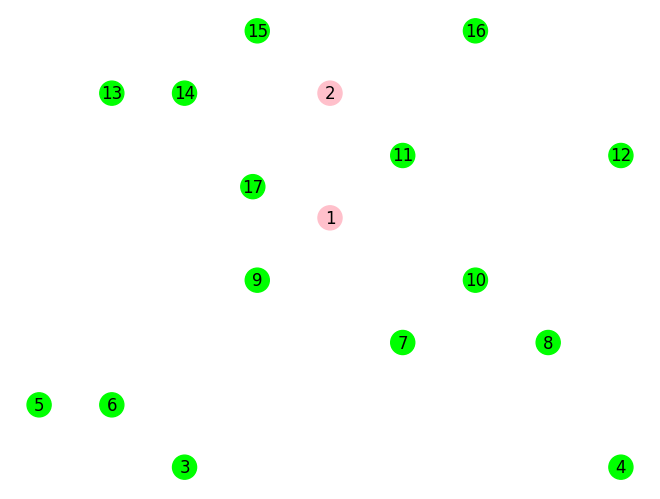

In [13]:
G = nx.DiGraph()
color_list = list()
G.add_nodes_from(list(range(1,len(all_nodes_det)+1)))
for node in G:
    if node in list(depot_coor['Depot']):
        color_list.append('pink')
    else:
        color_list.append('lime')
nx.draw(G, pos=coor_dic, node_color=color_list, with_labels=True)
plt.show()

In [14]:
m = len(depot_coor)         # Number of depot
n = len(customer_det)       # Number of customer
L = [i for i in depot_coor['Depot']]        # List of depot
V = {i : depot_coor['No of vehicles'][i] for i in L}        # Number of vehicle at each depot
V_ = {i : [j for j in range(1, depot_coor['No of vehicles'][i] + 1)] for i in L}   # Set of vehicle for each depot as dictionary
C = [i for i in customer_det['Customer']]       # List of customers
N = [i for i in all_nodes_det['Node']]         # List of all nodes
CN = [i for i in N if i > len(L)]         # List of customer nodes
Q = depot_coor['Capacity'][1]          # Capacity of vehicle [same for all vehicles]
D = depot_coor['Max allowed distance'][1]           # Max allowed distance for vehicle [same for all vehicles]
T = depot_coor['Max allowed time'][1]        # Max allowed time [same for all vehicles]
q = {i: all_nodes_det['Demand'][i] for i in N}        # Demand dictionary of all nodes
s = {i : all_nodes_det['Service Time'][i] for i in N}        # Service time for all nodes

# Coordinates of all nodes
x_coor = {i : all_nodes_det['X coordinate'][i] for i in N}
y_coor = {i : all_nodes_det['Y coordinate'][i] for i in N}
x_coor_list = [v for v in x_coor.values()]
y_coor_list = [v for v in y_coor.values()]

In [15]:
def index_condition(i, j, k, l):
    if i != j and (i not in L or j not in L):
        if i in L and i == l:
            return True
        elif i in L and i != l:
            return False
        elif j in L and j == l:
            return True
        elif j in L and j != l:
            return False
        else:
            return True
    else:
        return False

In [16]:
index_set = [(i, j, k, l) for i in N for j in N for l in L for k in V_[l] if index_condition(i, j, k, l)]
d = {(i,j) : distance_matrix[i][j] for i, j, k, l in index_set}
t = {(i,j) : travel_time_matrix[i][j] for i, j, k, l in index_set}

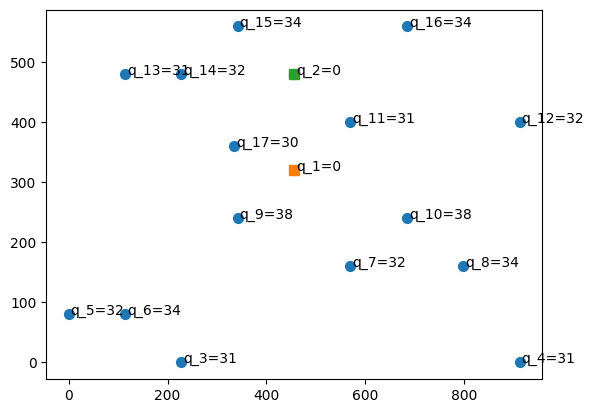

In [17]:
plt.scatter(x_coor_list, y_coor_list,s=50)
for i in N:
    plt.annotate('q_%d=%d'%(i, q[i]),(x_coor_list[i-1] + 4, y_coor_list[i-1]), fontsize=10)
plt.scatter(x_coor_list[0], y_coor_list[0], marker='s',s=50)
plt.scatter(x_coor_list[1], y_coor_list[1], marker='s',s=50)


In [18]:
model = Model(name='MCVRP')

In [19]:
# for m depot and n customers and v vehicles per depot then number of binary variable = (2m + n - 3)vmn
# for m depot and n customers and v vehicles per depot then number of continous variable = n
# for m depot and n customers and v vehicles per depot then number of constraints = (m + n^2 + 3)vm + 2n

In [20]:
x = model.binary_var_dict(index_set,name='x')
u = model.continuous_var_dict(CN, ub=Q, name='u')

In [21]:
model.minimize(model.sum(d[i,j] * x[i,j,k,l] for i,j,k,l in index_set))

In [22]:
c1 = model.add_constraints((model.sum(x[i,j,k,l] for i in N if index_condition(i, j, k, l)) ==
                            model.sum(x[j,i,k,l] for i in N if index_condition(i, j, k, l))
                            for j in N for l in L for k in V_[l]), names='flow_constraints')

c2 = model.add_constraints((model.sum(x[i,j,k,l] for i in N for l in L for k in V_[l] if index_condition(i, j, k, l)) == 1
                            for j in CN), names='customer_veh_constraints')

c3 = model.add_constraints((model.sum(q[j] * x[i,j,k,l] for j in N for i in N if index_condition(i, j, k, l)) <= Q
                            for l in L for k in V_[l]), names='Capacity Constraints')

c4 = model.add_constraints((u[j] - u[i] >= q[j] - Q * (1 - x[i,j,k,l])
                            for i in CN for j in CN for l in L for k in V_[l] if i != j), names='sub_tour_elimination_1')

c5 = model.add_constraints((u[i] <= Q - q[i] for i in CN), names='sub_tour_elimination_2')

c6 = model.add_constraints((model.sum(d[i,j] * x[i,j,k,l] for i in N for j in N if index_condition(i,j, k, l)) <= D
                            for l in L for k in V_[l]), names='tour_distance_limit')

c7 = model.add_constraints((model.sum((t[i,j] + s[j]) * x[i,j,k,l] for i in N for j in N if index_condition(i,j, k, l)) <= T
                            for l in L for k in V_[l]), names='tour_time_limit')

In [23]:
model.print_information()

Model: MCVRP
 - number of variables: 975
   - binary=960, integer=0, continuous=15
 - number of constraints: 950
   - linear=950
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP


In [24]:
a = model.solve(log_output=True)

Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIP Presolve eliminated 19 rows and 0 columns.
MIP Presolve modified 692 coefficients.
Reduced MIP has 931 rows, 975 columns, and 8160 nonzeros.
Reduced MIP has 960 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (3.99 ticks)
Probing time = 0.00 sec. (3.67 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 931 rows, 975 columns, and 8160 nonzeros.
Reduced MIP has 960 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (5.90 ticks)
Probing time = 0.02 sec. (3.66 ticks)
Clique table members: 1718.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.02 sec. (2.02 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Intege

In [25]:
model.solve_status

<JobSolveStatus.OPTIMAL_SOLUTION: 2>

In [26]:
model.print_solution()

objective: 4105
status: OPTIMAL_SOLUTION(2)
  x_1_10_1_1=1
  x_1_17_2_1=1
  x_2_14_2_2=1
  x_2_16_1_2=1
  x_3_9_2_1=1
  x_4_7_1_1=1
  x_5_6_2_1=1
  x_6_3_2_1=1
  x_7_1_1_1=1
  x_8_4_1_1=1
  x_9_1_2_1=1
  x_10_8_1_1=1
  x_11_2_1_2=1
  x_12_11_1_2=1
  x_13_15_2_2=1
  x_14_13_2_2=1
  x_15_2_2_2=1
  x_16_12_1_2=1
  x_17_5_2_1=1
  u_3=149.000
  u_4=161.000
  u_5=84.000
  u_6=118.000
  u_7=193.000
  u_8=130.000
  u_9=187.000
  u_10=96.000
  u_11=194.000
  u_12=163.000
  u_13=32.000
  u_14=1.000
  u_15=66.000
  u_16=131.000


In [27]:
active_arcs = [a for a in index_set if x[a].solution_value > 0.9]

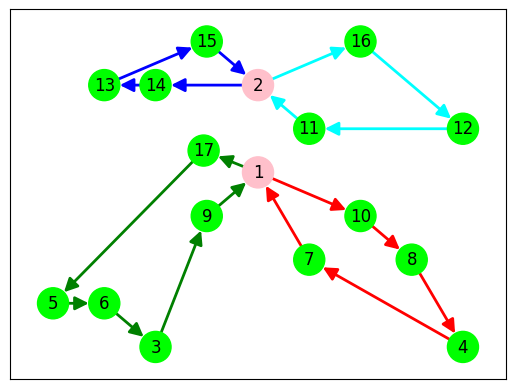

In [28]:
color_dic = {(1,1) : 'red', (1,2) : 'cyan', (2,1) : 'green', (2,2) : 'blue'}
edge_color_list = []
edge_list = []
for i,j,k,l in active_arcs:
    edge_list.append((i,j, {'veh' : k, 'depot' : l}))
G.add_edges_from(edge_list)
for edge in G.edges(data=True):
    edge_color_list.append(color_dic[edge[2]['veh'], edge[2]['depot']])
nx.draw_networkx(G, pos=coor_dic, node_size=500, node_color=color_list, edge_color=edge_color_list, width=2, arrowsize=20, with_labels=True)
plt.show()

In [29]:
logistic_dis_dic, logistic_time_dic = {}, {}
for l in L:
    for k in V_[l]:
        logistic_dis_dic[k, l] = sum(d[i,j] * x[i,j,k,l].solution_value for i in N for j in N if index_condition(i,j, k, l) and (i,j,k,l) in active_arcs)
        logistic_time_dic[k, l] = sum((t[i,j] + s[j]) * x[i,j,k,l].solution_value for i in N for j in N if index_condition(i,j, k, l) and (i,j,k,l) in active_arcs)

In [30]:
print(f'Logistic distance of every vehicles : \n')
for key in logistic_dis_dic.keys():
    print(f'Logistic distance of vehicle_{key[0]} from depot_{key[1]} is {logistic_dis_dic[key[0],key[1]]}')
print('\nLogistic time of every vehicles : \n')
for key in logistic_time_dic.keys():
    print(f'Logistic time of vehicle_{key[0]} from depot_{key[1]} is {logistic_time_dic[key[0],key[1]].round(2)}')

Logistic distance of every vehicles : 

Logistic distance of vehicle_1 from depot_1 is 1160.0
Logistic distance of vehicle_2 from depot_1 is 1215.0
Logistic distance of vehicle_1 from depot_2 is 1003.0
Logistic distance of vehicle_2 from depot_2 is 727.0

Logistic time of every vehicles : 

Logistic time of vehicle_1 from depot_1 is 37.34
Logistic time of vehicle_2 from depot_1 is 38.47
Logistic time of vehicle_1 from depot_2 is 30.98
Logistic time of vehicle_2 from depot_2 is 24.22
